In [1]:
import numpy as np
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import time
import logging
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import sys
from matplotlib import ticker

/home/roman/.local/lib/python2.7/site-packages/requests/__init__.py:83: RequestsDependencyWarning: Old version of cryptography ([1, 2, 3]) may cause slowdown.
  warnings.warn(warning, RequestsDependencyWarning)


In [2]:
import pybullet as p
import gym
from gym import spaces
import numpy as np
import pybullet_data
import time
from scipy.spatial.transform import Rotation
import matplotlib.pyplot as plt


class PushEnv(gym.Env):
    """
    Action: [0 -> stay, 1 -> left, 2 -> right, 3 -> forward, 4 -> backward]
    Observation: [x, y]
    Reward: 1/(target_distance+ 1) in [0, 1]
    """

    def __init__(self):
        
        self.rew_scale = 1.
        
        # domain boundaries
        self.minp = 0.0
        self.maxp = 0.4

        self.maxv = 1.5

        self.arm_length = 0.5 * self.maxp
        self.deacceleration = 0.4
        # target position
        self.target_position = np.r_[0.8 * self.maxp, 0.5 * self.maxp]

        self.low = np.r_[self.minp, self.minp, -self.maxv, -self.maxv, -0.2*self.maxp, -0.2*self.maxp, -4.]
        self.high = np.r_[self.maxp, self.maxp, +self.maxv, +self.maxv, 0.2*self.maxp, 0.2*self.maxp, 4.]

        # parameters for the simulation
        self.velocity_increment = 0.06
        self.control_hz = 30.
        self.sim_hz = 240.
        self.max_force = 400 # force of manipulator

        # define spaces in gym env
        self.action_space = spaces.Discrete(1)
        self.observation_range = spaces.Box(self.low, self.high)

        # initialize pybullet
        p.connect(p.DIRECT)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())

        # action set
        self.velocities = np.asarray([
            [0.0, 0.0],
            [0.0, -1.0],
            [0.0, 1.0],
            [1.0, 0.0],
            [-1.0, 0.0],
            [0.74, 0.74],
            [0.74, -0.74]
        ]) * self.velocity_increment
        
        # # #
        # displacement
        self.displacement = (0.3+ np.random.rand()* 0.4) * self.maxp
        self.offset_EE = 0.01*(-0.5 + np.random.rand())
        
        #
        self.offset_COM = 0.02*(-1. + 2.* np.random.rand())

        self.reset()

    def reset(self):
        # reset simulation
        p.resetSimulation()
        p.setGravity(0.0, 0.0, -10.0)

        # load environment
        p.loadURDF("plane.urdf")

        # load manipulation object
        self.object_id = p.loadURDF("urdfs/cuboid1.urdf", [0.05, self.displacement, 0.01])
        # load manipulator
        self.robot_position = np.r_[0.02, self.displacement+ self.offset_EE, 0.03] # XXXX
        rot = Rotation.from_rotvec(np.r_[0.0, 1.0, 0.0] * 0.5 * np.pi)
        self.robot_id = p.loadURDF("urdfs/cylinder.urdf", self.robot_position, rot.as_quat())

        # define constraint to track motion
        self.constraint_uid = p.createConstraint(self.robot_id, -1, -1, -1, p.JOINT_FIXED, [0.0, 0.0, 0.0],
                                                 [0., 0., 0.], self.robot_position, [0., 0., 0., 1.0], rot.as_quat())

        # object COM offset
        self.obj_offset_COM_local = np.array([0., self.offset_COM])

        # reset velocity vector
        self.velocity_vector = np.zeros(2)

        # return observation
        obs = self._get_obs()

        return obs

    def step(self, action):
        # number of steps (control frequency < simulation frequency)
        N_steps = int(self.sim_hz / self.control_hz)

        # accelerate
        dvelocity = self.velocities[action] / N_steps

        # continuously track motion
        for _ in range(N_steps):
            self.velocity_vector += dvelocity
            self.robot_position[:2] += self.velocity_vector / self.sim_hz

            p.changeConstraint(self.constraint_uid, jointChildPivot=self.robot_position, maxForce=self.max_force)
            p.stepSimulation()
            #time.sleep(1./10.)

        # get observation
        obs = self._get_obs()

        # calculate reward 0.01
        reward = 10.* self.rew_scale / (self.rew_scale + np.linalg.norm(obs[:2]+ obs[4:6] - self.target_position)) # 1/ dist(object_to_target)
        #reward = self.rew_scale* (0.3- np.linalg.norm(obs[4:6] - self.target_position))
        
        done = False

        # check domain violations
        if np.any(obs < self.low) or np.any(obs > self.high):
            done = True
            reward = 0.

        # if robot moves too far away from object
        rot_object_matrix = np.array([[np.cos(obs[-1]), np.sin(obs[-1])],
                                      [-np.sin(obs[-1]), np.cos(obs[-1])]])
        dist = np.dot(np.linalg.inv(rot_object_matrix[:2,:2]), obs[4:6])
        
        if np.abs(dist[0]) > 0.032 or np.abs(dist[1]) > 0.045:
            done = True
            reward = 0.

        return obs, reward, done, {}

    def _get_obs(self):
        # get object position
        pos_robot, _ = p.getBasePositionAndOrientation(self.robot_id)
        pos_object, rot_object_quat = p.getBasePositionAndOrientation(self.object_id)

        # add COM offset to object position
        r = Rotation.from_quat(rot_object_quat)
        rot_object_matrix = r.as_dcm()
        obj_offset_COM_global = np.dot(rot_object_matrix[:2,:2], self.obj_offset_COM_local)
        pos_object_COM = np.asarray(pos_object[:2])+ obj_offset_COM_global
        pos_object_COM -= pos_robot[:2]
        
        vel_object_lin, _ = p.getBaseVelocity(self.object_id)
        vel_robot_lin, _ = p.getBaseVelocity(self.robot_id)
        
        vel_object = np.asarray(vel_object_lin[:2])- np.asarray(vel_robot_lin[:2])

        return np.concatenate([np.asarray(pos_robot[:2]),
                               np.asarray(vel_robot_lin[:2]),
                               pos_object_COM,
                               np.array(p.getEulerFromQuaternion(rot_object_quat)[2]).reshape(-1)])


In [3]:
'''
Class structure for ALPaCA meta-RL code
'''

gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.13)

tf.app.flags.DEFINE_string('f', '', 'kernel')

flags = tf.app.flags
FLAGS = flags.FLAGS

# General Hyperparameters
# general
flags.DEFINE_integer("batch_size", 2, "Batch size for training")
flags.DEFINE_float("gamma", 0.90, "Discount factor")
flags.DEFINE_integer("N_episodes", 30000, "Number of episodes")
flags.DEFINE_integer("N_tasks", 2, "Number of tasks")
flags.DEFINE_integer("L_episode", 40, "Length of episodes")

# architecture
flags.DEFINE_integer("hidden_space", 64, "Dimensionality of hidden space")
flags.DEFINE_integer("latent_space", 8, "Dimensionality of latent space")
flags.DEFINE_string('non_linearity', 'leaky_relu', 'Non-linearity used in encoder')
flags.DEFINE_integer("nstep", 1, "n-step TD return")

# domain
flags.DEFINE_integer("action_space", 7, "Dimensionality of action space")  # only x-y currently
flags.DEFINE_integer("state_space", 7, "Dimensionality of state space")  # [x,y,theta,vx,vy,vtheta]

# posterior
flags.DEFINE_float("prior_precision", 0.1, "Prior precision (1/var)")
flags.DEFINE_float("noise_precision", 3., "Noise precision (1/var)")
flags.DEFINE_float("noise_precmax", 3.0, "Maximum noise precision (1/var)")
flags.DEFINE_integer("noise_Ndrop", 1, "Increase noise precision every N steps")
flags.DEFINE_float("noise_precstep", 1.001, "Step of noise precision s*=ds")

flags.DEFINE_integer("split_N", 20, "Increase split ratio every N steps")
flags.DEFINE_float("split_ratio", 0.85, "Initial split ratio for conditioning")
flags.DEFINE_float("split_ratio_max", 0.85, "Maximum split ratio for conditioning")
flags.DEFINE_integer("update_freq_post", 3, "Update frequency of posterior and sampling of new policy")

# exploration
flags.DEFINE_float("eps_initial", 0., "Initial value for epsilon-greedy")
flags.DEFINE_float("eps_final", 0., "Final value for epsilon-greedy")
flags.DEFINE_float("eps_step", 0.9997, "Multiplicative step for epsilon-greedy")

# target
flags.DEFINE_float("tau", 0.008, "Update speed of target network")
flags.DEFINE_integer("update_freq_target", 1, "Update frequency of target network")

# loss
flags.DEFINE_float("learning_rate", 5e-2, "Initial learning rate")
flags.DEFINE_float("lr_drop", 1.0003, "Drop of learning rate per episode")
flags.DEFINE_float("lr_final", 1e-4, "Final learning rate")
flags.DEFINE_float("grad_clip", 1e4, "Absolute value to clip gradients")
flags.DEFINE_float("huber_d", 1e1, "Switch point from quadratic to linear")
flags.DEFINE_float("regularizer", 1e-2, "Regularization parameter") # X

# reward
flags.DEFINE_float("rew_norm", 1e-2, "Normalization factor for reward")

# memory
flags.DEFINE_integer("replay_memory_size", 10000, "Size of replay memory")
flags.DEFINE_integer("iter_amax", 1, "Number of iterations performed to determine amax")
flags.DEFINE_integer("save_frequency", 50, "Store images every N-th episode")

#
flags.DEFINE_integer("random_seed", 2345, "Random seed for numpy and tensorflow")
flags.DEFINE_bool("load_model", True, "Load trained model")

#FLAGS = flags.FLAGS
#FLAGS(sys.argv)

np.random.seed(FLAGS.random_seed)
tf.set_random_seed(FLAGS.random_seed)

from QNetwork import QNetwork
from replay_buffer import replay_buffer

In [4]:
def eGreedyAction(x, epsilon=0.):
    ''' select next action according to epsilon-greedy algorithm '''
    if np.random.rand() >= epsilon:
        action = np.argmax(x)
    else:
        action = np.random.randint(FLAGS.action_space)
    return action

def create_dictionary(dir_name):
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)

Successully restored model from ./model/14-33-04_12-19/model-25000
Episodes...
0


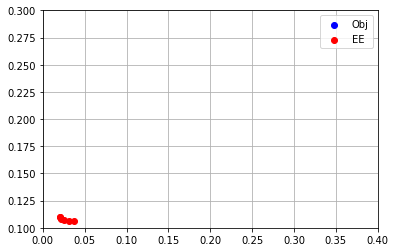

100


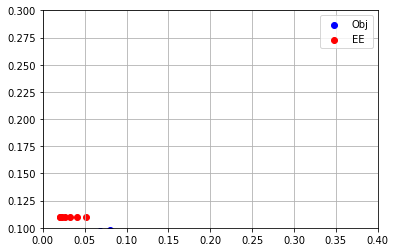

200


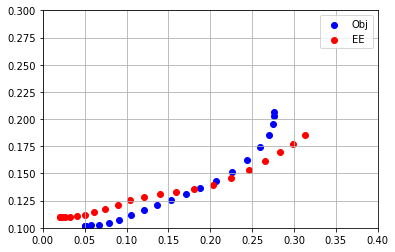

300


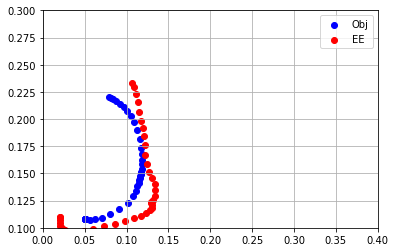

400


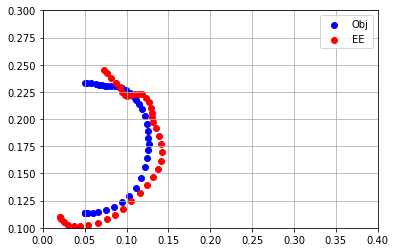

500


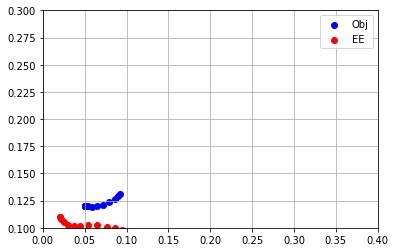

600


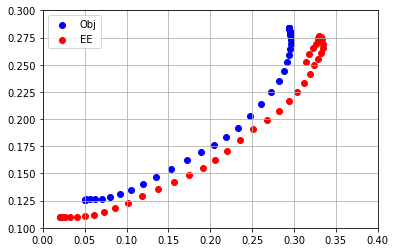

700


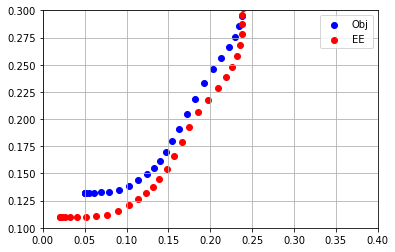

800


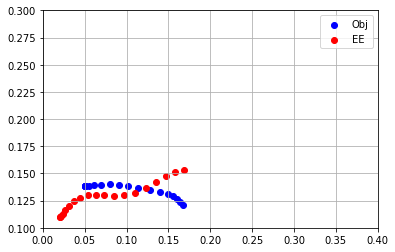

900


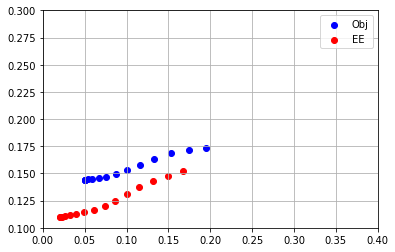

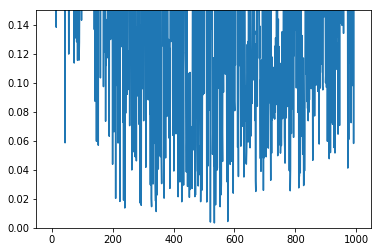

In [54]:
import logging
logging.getLogger("tensorflow").setLevel(logging.WARNING)
sim = simulation()

# Main Routine ===========================================================================
eps = 0.

counter = 0

maxp = 0.4

#
split_ratio = FLAGS.split_ratio
nstep = FLAGS.nstep
gamma = FLAGS.gamma

# folder for plotting --------------------------------------------------------------------
base_dir = './figures/' + time.strftime('%H-%M-%d_%m-%y')

# initialize replay memory and model
tempbuffer = replay_buffer(FLAGS.L_episode)  # buffer for episode

# initialize environment
env = PushEnv()
env.rew_scale = FLAGS.rew_norm

# initialize
noise_precision = FLAGS.noise_precision

N = 10

#
offset_COM = np.zeros(N**3)
offset_EE = np.zeros(N**3)
displacement = np.zeros(N**3)

for oc in range(N):
    for oe in range(N):
        for di in range(N):
            offset_COM[oc*N**2+ oe*N+ di] = 0.03*(-1.+ 2.* oc/ N)
            offset_EE[oc*N**2+ oe*N+ di] = 0.02*(-0.5+ 1.*oe/ N)
            displacement[oc*N**2+ oe*N+ di] = (0.3+ di/ N* 0.4)* env.maxp

#
tf.reset_default_graph()

with tf.Session(config=tf.ConfigProto(gpu_options=gpu_options)) as sess:
    
    # folder to save and restore model --------------------eps----------------------
    saver_dir = './model/' + time.strftime('%H-%M-%d_%m-%y') + '/'
    loader_dir = './model/14-33-04_12-19/'
    # 18-52-27_11-19
    # 18-57-27_11-19

    QNet = QNetwork(FLAGS, scope='QNetwork')
    Qtarget = QNetwork(FLAGS, scope='TargetNetwork')

    init = tf.global_variables_initializer()
    sess.run(init)

    if FLAGS.load_model == True:
            loader = tf.train.Saver(max_to_keep=6)
            loader.restore(sess, loader_dir+ 'model-15000')
            print('Successully restored model from ' + str(tf.train.latest_checkpoint(loader_dir)))  

    # report mean reward per episode
    reward_episode = []

    # target distance vs COM offset
    target_COM = []
    
    # count reward
    target_distance = []
    max_speed = []
    reward_episode = []

    # -------------------------------------------------------------------------------
    # loop episodes
    print("Episodes...")
    for episode in range(N**3):
        if episode % N**2 == 0:
            print(episode)

        # initialize buffer
        tempbuffer.reset()

        # reset environment
        env.offset_COM = offset_COM[episode%N**3] #0.02*(-1. + 2.* 5 / 10)
        env.offset_EE = offset_EE[episode%N**3] #0.01*(-0.5 + 10/ 10.)
        env.displacement = displacement[episode%N**3] #(0.3+ episode/ 100.* 0.4) * env.maxp
        state = env.reset()

        # network
        sess.run(QNet.sample_prior)

        # loop steps
        step = 0
        done = False
        td_accum = 0
        rw = []

        #
        speed_task = []
        
        #
        wt_bar, Lt_inv = sess.run([QNet.w0_bar, QNet.L0])
        Lt_inv = np.linalg.inv(Lt_inv)
        
        # -----------------
        if episode % N**2 == 0:
            Nx = 30
            Ny = 20

            mesh = generate_mesh()

            phi = sess.run(QNet.phi, feed_dict={QNet.state: mesh})

            Q = np.einsum('im,bia->ba', wt_bar, phi)
            dQ = np.einsum('bia,ij,bja->ba', phi, Lt_inv, phi)

            argmax_Q = np.argmax(Q, axis=1)
            Vpost = Q[np.arange(len(Q)), argmax_Q]
            dVpost = np.sqrt(dQ[np.arange(len(Q)), argmax_Q])+ 1./np.sqrt(FLAGS.noise_precmax)

            Policy = argmax_Q
            Policy[0:FLAGS.action_space] = np.arange(FLAGS.action_space)

            fig, ax = plt.subplots(figsize=[16,6], ncols=2)

            im = ax[0].imshow(Vpost.reshape(Ny, Nx), extent=[0, maxp, 0, maxp], aspect='auto')  # (y, x)
            ax[0].set_title('state value mean')
            ax[0].set_xlabel('x [m]')
            ax[0].set_ylabel('y [m]')
            cbar = fig.colorbar(im, ax=ax[0], orientation="horizontal", fraction=0.064, pad=0.15)
            cbar.set_clim(0., 25.0)

            im = ax[1].imshow(dVpost.reshape(Ny, Nx), extent=[0, maxp, 0, maxp], aspect='auto')  # (y, x)
            ax[1].set_title('state value std')
            ax[1].set_xlabel('x [m]')
            ax[1].set_ylabel('y [m]')
            cbar = fig.colorbar(im, ax=ax[1], orientation="horizontal", fraction=0.062, pad=0.15)
            cbar.set_clim(0., 5.0)

            plt.savefig('presentation/' + 'Episode_' + str(episode)+ '_step_'+ str(step))
            plt.close()
            
        #
        while (step < FLAGS.L_episode) and (done == False):

            # take a step
            Qval = sess.run(QNet.Qout, feed_dict={QNet.state: state.reshape(-1,FLAGS.state_space)})[0]
            action = eGreedyAction(Qval, eps)
            next_state, reward, done, _ = env.step(action)

            # store experience in memory
            new_experience = [state, action, reward, next_state, done]
            tempbuffer.add(new_experience)

            # actual reward
            rw.append(1.*reward/ FLAGS.rew_norm)
            speed_task.append(np.linalg.norm(next_state[2:4]- state[2:4]))

            # update state, and counters
            state = next_state.copy()
            step += 1

            # update posterior
            if (step) % FLAGS.update_freq_post == 0 and step < split_ratio* FLAGS.L_episode:
                reward_train = np.zeros([step, ])
                state_train = np.zeros([step, FLAGS.state_space])
                next_state_train = np.zeros([step, FLAGS.state_space])
                action_train = np.zeros([step, ])
                done_train = np.zeros([step, ])
                
                # fill arrays
                for k, experience in enumerate(tempbuffer.buffer):
                    # [s, a, r, s', a*, d]
                    state_train[k] = experience[0]
                    action_train[k] = experience[1]
                    reward_train[k] = experience[2]
                    next_state_train[k] = experience[3]
                    done_train[k] = experience[4]

                # update
                _, wt_bar, Lt_inv = sess.run([QNet.sample_post, QNet.wt_bar, QNet.Lt_inv],
                            feed_dict={QNet.context_state: state_train,
                                       QNet.context_action: action_train,
                                       QNet.context_reward: reward_train,
                                       QNet.context_state_next: next_state_train,
                                       QNet.context_done: done_train,
                                       QNet.nprec: noise_precision})
                
                
                # -----------------
                if episode % N**2 == 0:
                    Nx = 30
                    Ny = 20

                    mesh = generate_mesh()

                    phi = sess.run(QNet.phi, feed_dict={QNet.state: mesh})

                    Q = np.einsum('im,bia->ba', wt_bar, phi)
                    dQ = np.einsum('bia,ij,bja->ba', phi, Lt_inv, phi)

                    argmax_Q = np.argmax(Q, axis=1)
                    Vpost = Q[np.arange(len(Q)), argmax_Q]
                    dVpost = np.sqrt(dQ[np.arange(len(Q)), argmax_Q])+ 1./np.sqrt(FLAGS.noise_precmax)

                    Policy = argmax_Q
                    Policy[0:FLAGS.action_space] = np.arange(FLAGS.action_space)

                    fig, ax = plt.subplots(figsize=[16,6], ncols=2)

                    im = ax[0].imshow(Vpost.reshape(Ny, Nx),
                                      extent=[0, maxp, 0, maxp], aspect='auto')  # (y, x)
                    ax[0].set_title('state value mean')
                    ax[0].set_xlabel('x [m]')
                    ax[0].set_ylabel('y [m]')
                    cbar = fig.colorbar(im, ax=ax[0], orientation="horizontal", fraction=0.064, pad=0.15)
                    cbar.set_clim(0., 25.0)

                    im = ax[1].imshow(dVpost.reshape(Ny, Nx),
                                      extent=[0, maxp, 0, maxp], aspect='auto')  # (y, x)
                    ax[1].set_title('state value std')
                    ax[1].set_xlabel('x [m]')
                    ax[1].set_ylabel('y [m]')
                    cbar = fig.colorbar(im, ax=ax[1], orientation="horizontal", fraction=0.062, pad=0.15)
                    cbar.set_clim(0., 5.0)

                    plt.savefig('presentation/' + 'Episode_' + str(episode)+ '_step_'+ str(step))
                    plt.close()
                
        #
        reward_episode.append(np.sum(np.asarray(rw)))
                
        #
        if episode % N**2 == 0:
            reward_train = np.zeros([step, ])
            state_train = np.zeros([step, FLAGS.state_space])
            next_state_train = np.zeros([step, FLAGS.state_space])
            action_train = np.zeros([step, ])
            done_train = np.zeros([step, ])

            # fill arrays
            for k, experience in enumerate(tempbuffer.buffer):
                # [s, a, r, s', a*, d]
                state_train[k] = experience[0]
                action_train[k] = experience[1]
                reward_train[k] = experience[2]
                next_state_train[k] = experience[3]
                
                done_train[k] = experience[4]
                
            x_pos = state_train[:,0]+ state_train[:,4]
            y_pos = state_train[:,1]+ state_train[:,5]
            
            x_pos_EE = state_train[:,0]
            y_pos_EE = state_train[:,1]

            plt.figure()
            plt.grid()
            plt.scatter(x_pos, y_pos, color='b')
            plt.scatter(x_pos_EE, y_pos_EE, color='r')
            plt.legend(['Obj', 'EE'])
            plt.xlim([0., 0.4])
            plt.ylim([0.1, 0.3])
            plt.show()        

        # -----------------------------------------------------------------------

        # target distance vs COM offset
        position_object = np.array([state_train[-1, 0] + state_train[-1, 4],
                                    state_train[-1, 1] + state_train[-1, 5]])
        target_COM.append([np.linalg.norm(env.target_position- position_object),
                          np.linalg.norm(env.obj_offset_COM_local)])

        # final distance to target
        target_distance.append(np.linalg.norm(env.target_position- state[:2]- state[4:6]))

        # maximum speed of robot arm
        speed_task = np.asarray(speed_task)
        max_speed.append(np.max(speed_task) * env.control_hz)
        
        #
        if np.linalg.norm(env.target_position- state[:2]- state[4:6]) < 0.03:
            #sim.simulate(tempbuffer, env.offset_COM, counter)
            counter += 1
    
    plt.figure()
    plt.plot(target_distance)
    plt.ylim([0., 0.15])
    plt.show()

averaged reward
1670.0544153698374+-1.4728315908668632
averaged reward displacement


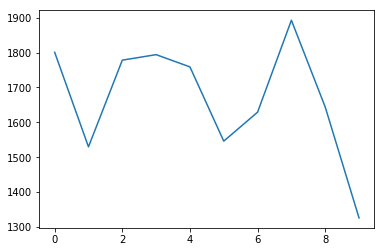

averaged reward COM


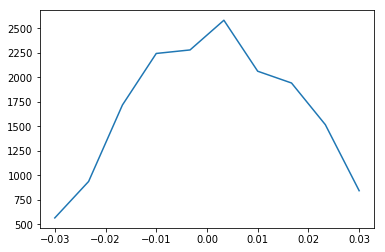

averaged reward EE


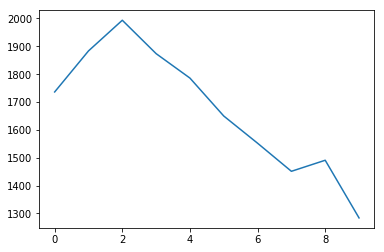

In [36]:
import pandas as pd

plt.rcParams.update({'font.size': 10})

reward_episode = np.asarray(reward_episode)

'''
df = pd.dataframe()
data = {++'reward': np.mean(reward_episode)}
df = pd.DataFrame(data=data)

with open('reward.csv', 'a') as f:
    df.to_csv(f, header=False)
'''

# averaged reward
print('averaged reward')
print(str(np.mean(reward_episode))+ '+-'+ str(np.std(reward_episode)/N**3))

# averaged reward for given displacement [bs, oc, oe, di]
reward_episode = reward_episode.reshape(-1, N, N, N)
print('averaged reward displacement')
plt.figure()
plt.plot(np.mean(reward_episode, axis=(0,1,2)))
plt.show()

# averaged reward for given COM offset
print('averaged reward COM')
plt.figure()
plt.plot(np.linspace(-0.03, 0.03, 10), np.mean(reward_episode, axis=(0,2,3)))
plt.show()

# averaged reward for given EE offset
print('averaged reward EE')
plt.figure()
plt.plot(np.mean(reward_episode, axis=(0,1,3)))
plt.show()


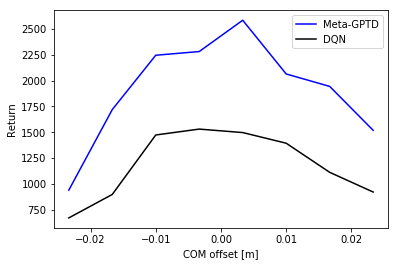

In [45]:
DQN_COM = np.array([358.028, 669.991, 897.225, 1472.723, 1529.722,
 1496.132, 1393.053, 1111.3408, 920.606, 786.289])
GPTD_COM = np.mean(reward_episode, axis=(0,2,3))

plt.figure()
plt.plot(np.linspace(-0.03, 0.03, 10)[1:-1], GPTD_COM[1:-1], c='b')
plt.plot(np.linspace(-0.03, 0.03, 10)[1:-1], DQN_COM[1:-1], c='k')
plt.xlabel('COM offset [m]')
plt.ylabel('Return')
plt.legend(['Meta-GPTD', 'DQN'])
plt.savefig('./return_COM_comparison')

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

class simulation():
    def __init__(self):
        pass
    
    # ---------------------------------------------------
    def init_plot(self):
        self.ax.set_xlim(0, 0.4)
        self.ax.set_ylim(0.08, 0.32)
        self.ax.set_xticks([0., 0.1, 0.2, 0.3, 0.4])
        self.ax.set_yticks([0.1, 0.2, 0.3])
        self.ax.set_xlabel('x [m]')
        self.ax.set_ylabel('y [m]')
        self.ax.set_aspect('equal')
        plt.savefig('push_GPTD_initial_'+ str(self.counter))
        
        return self.ln_EE, self.ln_Obj, self.rectangle, self.cylinder, self.com, self.com_true
    
     # --------------------------------------------------
    def update(self,i):
        # EE position
        self.x_EE.append(self.state_train[i,0])
        self.y_EE.append(self.state_train[i,1])
        self.ln_EE.set_data(self.x_EE, self.y_EE)

        # Rectangle position
        phi = self.state_train[i,6]
        rotmat = np.array([[np.cos(phi), -np.sin(phi)],
                          [np.sin(phi), np.cos(phi)]])

        r_cen_corn = np.dot(rotmat, np.array([0.0075, 0.045+ self.offset_COM]))


        self.rectangle._angle = (phi/np.pi*180)
        self.rectangle.set_xy([self.state_train[i,0]+ self.state_train[i,4]- r_cen_corn[0],
                          self.state_train[i,1]+ self.state_train[i,5]- r_cen_corn[1]])

        # Obj COM position
        r_cen_corn = np.dot(rotmat, np.array([0.0, self.offset_COM]))
        self.com_true.center = (self.state_train[i,0]+ self.state_train[i,4]- r_cen_corn[0],
                                self.state_train[i,1]+ self.state_train[i,5]- r_cen_corn[1])

        self.x_Obj.append(self.state_train[i,0]+ self.state_train[i,4]- r_cen_corn[0])
        self.y_Obj.append(self.state_train[i,1]+ self.state_train[i,5]- r_cen_corn[1])
        self.ln_Obj.set_data(self.x_Obj, self.y_Obj)

        self.com.center = (self.state_train[i,0]+ self.state_train[i,4],
                            self.state_train[i,1]+ self.state_train[i,5])

        # EE position
        self.cylinder.center = (self.state_train[i,0],
                                self.state_train[i,1])



        return self.ln_EE, self.ln_Obj, self.rectangle, self.cylinder, self.com, self.com_true
    
    # -----------------------------------------------
    def simulate(self, buffer, offset_COM, counter):
        self.state_train = np.zeros([step, FLAGS.state_space+1])
        self.offset_COM = offset_COM
        self.counter = counter

        # fill arrays
        for k, experience in enumerate(buffer.buffer):
            # [s, a, r, s', a*, d]
            self.state_train[k] = experience[0]

        #
        fig, self.ax = plt.subplots(figsize=(10,10))
        plt.rcParams.update({'font.size': 30})
        plt.plot(0.32, 0.2, 'xr', markersize=22, linewidth=22)
        self.x_EE, self.y_EE = [], []
        self.x_Obj, self.y_Obj = [], []
        self.ln_EE, = plt.plot([], [], color=[0.1,0.,0.8], linewidth=6, alpha=0.3)
        self.ln_Obj, = plt.plot([], [], color=[0.8, 0.3, 0.], linewidth=6, alpha=0.3)

        # rectangle ---------------------------------------
        self.rectangle = plt.Rectangle((self.state_train[0,0]+ self.state_train[0,4]- 0.0075,
                                       self.state_train[0,1]+ self.state_train[0,5]- 0.045- self.offset_COM),
                              0.015, 0.09, fc=[0.8, 0.3, 0.])
        self.ax.add_patch(self.rectangle)

        # COM
        self.com_true = plt.Circle((self.state_train[0,0]+ self.state_train[0,4],
                                    self.state_train[0,1]+ self.state_train[0,5]- self.offset_COM),
                                     0.005, fc=[0.6, 0.2, 0.])
        self.ax.add_patch(self.com_true)

        self.com = plt.Circle((self.state_train[0,0]+ self.state_train[0,4],
                               self.state_train[0,1]+ self.state_train[0,5]),
                                0.005, fc='k')
        self.ax.add_patch(self.com)

        # cylinder
        self.cylinder = plt.Circle((self.state_train[0,0],
                                    self.state_train[0,1]),
                                    0.017, fc=[0.1,0.,0.8])
        self.ax.add_patch(self.cylinder)

        # --------------------------------------------------
        ani = FuncAnimation(fig, self.update, frames=np.arange(len(self.state_train)),
                            init_func=self.init_plot, interval=200, blit=True)
        #HTML(ani.to_html5_video())

        ani.save('push_GPTD_'+ str(self.counter)+'.mp4', writer="ffmpeg")
        fig.show()
        
        plt.savefig('push_GPTD_final_'+ str(self.counter))

In [12]:
maxp = 0.4

def generate_mesh(Nx=30, Ny=20):
    #
    vx = 0.
    vy = 0.
    friction = 0.12

    # loop over x,y of state
    px_robot = np.linspace(0., maxp, Nx)
    py_robot = np.linspace(0., maxp, Ny)

    px_robot_mesh, py_robot_mesh = np.meshgrid(px_robot, py_robot)

    vx_robot = vx * np.ones([Nx * Ny, 1])
    vy_robot = vy * np.ones([Nx * Ny, 1])

    px_object = np.zeros_like(px_robot_mesh)+ 0.02 # ~ radius
    py_object = np.zeros_like(py_robot_mesh)
    ptheta_object = np.zeros_like(py_robot_mesh)

    vx_object =vx * np.ones([Nx * Ny, 1])
    vy_object = vy * np.ones([Nx * Ny, 1])

    mesh = np.concatenate([px_robot_mesh.reshape(-1, 1),
                           py_robot_mesh.reshape(-1, 1),
                           vx_robot.reshape(-1, 1),
                           vy_robot.reshape(-1, 1),
                           px_object.reshape(-1, 1),
                           py_object.reshape(-1, 1),
                           ptheta_object.reshape(-1,1)], axis=1)

    return mesh